In [240]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit

sys.path.insert(0, './radiometric')
from LUT_functions import pixel_registration, create_LUT_df
import scipy

# Seaborn for plotting and styling
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid", {'axes.grid' : False})


params = {'legend.fontsize' :  10,
          'figure.figsize'  :  (10, 10),
          'axes.labelsize'  :  14,
          'axes.titlesize'  :  14,
          'xtick.labelsize' :  15,
          'ytick.labelsize' :  15}
plt.rcParams.update(params)

In [5]:
#choose filepath to desired data
path =path = '/Volumes/KESU/mar02/polarized/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

In [8]:
#will create a df and print the names of the keys in the original hdf5 file
df = create_LUT_df(path,'0deg.h5')
df

imgs1  \
0  [[22469.0, 22463.0, 22465.0, 22468.0, 22479.0,...   
1  [[22469.0, 22463.0, 22464.0, 22468.0, 22479.0,...   
2  [[22473.0, 22468.0, 22472.0, 22467.0, 22484.0,...   
3  [[22472.0, 22484.0, 22451.0, 22458.0, 22484.0,...   
4  [[22478.0, 22470.0, 22465.0, 22455.0, 22474.0,...   
5  [[22467.0, 22468.0, 22466.0, 22460.0, 22488.0,...   
6  [[22466.0, 22461.0, 22463.0, 22454.0, 22488.0,...   
7  [[22448.0, 22471.0, 22470.0, 22469.0, 22483.0,...   
8  [[22460.0, 22455.0, 22472.0, 22464.0, 22490.0,...   
9  [[22482.0, 22461.0, 22456.0, 22458.0, 22440.0,...   

                                               imgs2  temps1  temps2  
0  [[23078.0, 23076.0, 23045.0, 23074.0, 23074.0,...    38.3    39.0  
1  [[23078.0, 23076.0, 23045.0, 23074.0, 23074.0,...    38.3    39.0  
2  [[23073.0, 23077.0, 23060.0, 23084.0, 23083.0,...    38.3    39.0  
3  [[23061.0, 23067.0, 23044.0, 23077.0, 23068.0,...    38.3    39.0  
4  [[23060.0, 23078.0, 23053.0, 23083.0, 23076.0,...    38.3    39.0  
5  [[23061.0, 23065.0, 23059.0, 23077.0, 23067.0,...    38.3    39.0  
6  [[23046.0, 23058.0, 23055.0, 23081.0, 23065.0,...    38.4    39.1  
7  [[23057.0, 23060.0, 23027.0, 23072.0, 23066.0,...    38.4    39.1  
8  [[23057.0, 23074.0, 23047.0, 23080.0, 23066.0,...    38.4    39.1  
9  [[23059.0, 23070.0, 23042.0, 23071.0, 23065.0,...    38.4    39.1

In [79]:
waves= np.linspace(7,12,61)
lps = np.round(np.linspace(0,350,36),1)
angles = np.round(np.linspace(-5,5,25),1)

In [74]:
##import nuc calibration
sys.path.insert(0, './NUC')
from NUC_functions import import_NUC, apply_NUC
cal_path = '/Volumes/KESU/calibration_files/NUC030221.h5'

m1,b1,T_ref1,m2,b2,T_ref2 = import_NUC(cal_path)

In [78]:
#apply pixel registration and NUC to full dataset

#select ROI
ymin2 = 105; ymax2 = 130;
ymin1 = 130; ymax1 = 155;

mean_ims1 =[]
mean_ims2 =[]
std_ims1  =[]
std_ims2  =[]

mean_ims1n =[]
mean_ims2n =[]
std_ims1n  =[]
std_ims2n  =[]

for i in lps:
    #will create a df and print the names of the keys in the original hdf5 file
    df = create_LUT_df(path,str(int(i))+'deg.h5')
    
    corrected_images1= [] ; corrected_images1n= [];
    corrected_images2= [] ; corrected_images2n= []

    for i in range(len(df)):
        #first without NUC correction
        r = df['imgs1'][i];
        c = pixel_registration(r,cal_file1,waves,ymin1,ymax1)
        
        #now with NUC correction
        T = df['temps1'][i];
        rn = apply_NUC(r,T,m1,b1,T_ref1)
        cn = pixel_registration(rn,cal_file1,waves,ymin1,ymax1)
        
        corrected_images1.append(c)
        corrected_images1n.append(cn)

        #first without NUC correction
        r = df['imgs2'][i];
        c = pixel_registration(r,cal_file2,waves,ymin2,ymax2)
        
        #now with NUC correction
        T = df['temps2'][i];
        rn = apply_NUC(r,T,m2,b2,T_ref2)
        cn = pixel_registration(rn,cal_file2,waves,ymin2,ymax2)
        
        corrected_images2.append(c)
        corrected_images2n.append(cn)

    mean_ims1.append(np.mean(corrected_images1,axis = 0))
    mean_ims1n.append(np.mean(corrected_images1n,axis = 0))
    mean_ims2.append(np.mean(corrected_images2,axis = 0))
    mean_ims2n.append(np.mean(corrected_images2n,axis = 0))


    std_ims1.append(np.std(corrected_images1,axis = 0))
    std_ims2.append(np.std(corrected_images2,axis = 0))
    std_ims1n.append(np.std(corrected_images1n,axis = 0))
    std_ims2n.append(np.std(corrected_images2n,axis = 0))

In [80]:
d = {'lps': lps, 'ims1': list(mean_ims1),'s1': list(std_ims1), 'ims2':list(mean_ims2),'s2': list(std_ims2)}
dn = {'lps': lps, 'ims1': list(mean_ims1n),'s1': list(std_ims1n), 'ims2':list(mean_ims2n),'s2': list(std_ims2n)}


In [81]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

dfn = pd.DataFrame.from_dict(dn, orient='index')
dfn = dfn.transpose()



In [82]:

df.to_hdf('/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_data/LUT/df_pol.h5', key='s')
dfn.to_hdf('/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_data/LUT/df_pol_NUC.h5', key='s')


/Users/kirahart/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['lps', 'ims1', 's1', 'ims2', 's2'], dtype='object')]

  pytables.to_hdf(


In [86]:
def finv(y,A,B):
    return np.abs(((y-B)/A))**0.5


In [124]:
#import radiometric data

#choose filepath to desired data
save_path =   '/Volumes/KESU/calibration_files/'
name =  "LUT030221.h5" 

hf = h5py.File(save_path+name, 'r')
B2 = hf.get('B2')
B1 = hf.get('B1')
A2 = hf.get('A2')
A1 = hf.get('A1')
transmission1 = hf.get('transmission1')
transmission2 = hf.get('transmission2')

transmission1

<HDF5 dataset "transmission1": shape (34, 61), type "<f8">

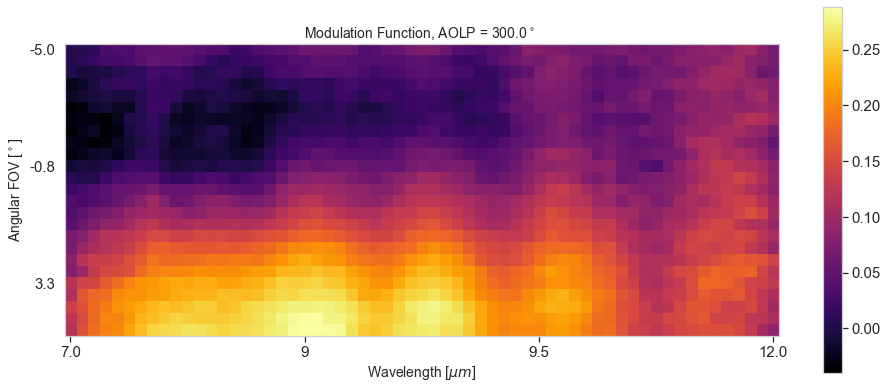

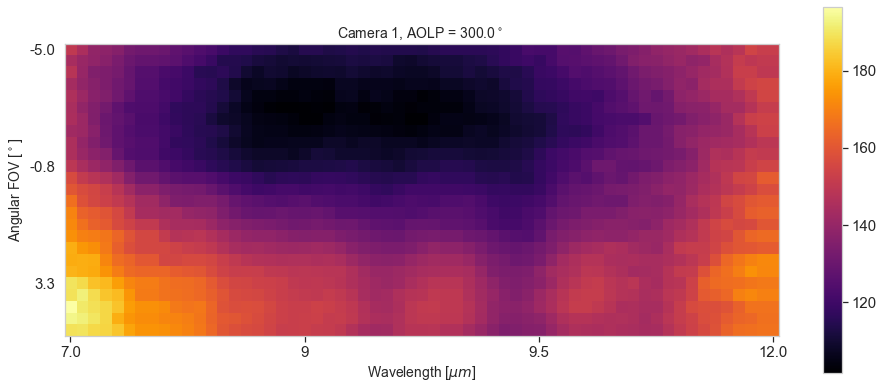

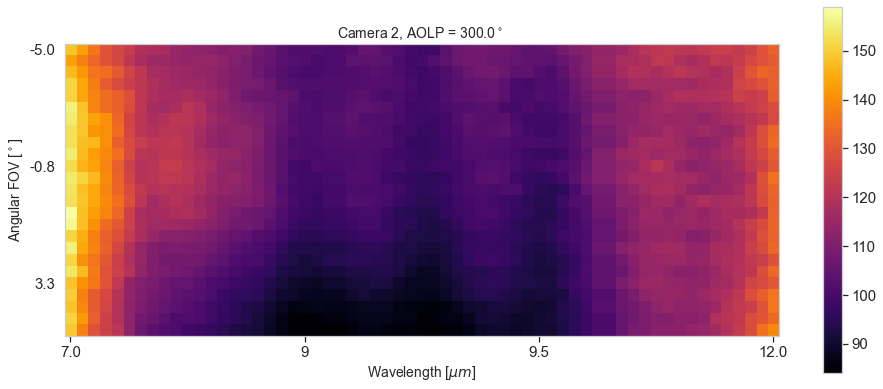

In [198]:

j = 30;
I1 = finv(df['ims1'][j],A1,B1)
I2 = finv(df['ims2'][j],A2,B2)
plt.matshow((I1-I2)/(I1+I2),cmap = 'inferno' )
plt.colorbar()
plt.ylabel('Angular FOV [$^\circ$]')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 10,20], [angles[0], angles[10],angles[20]])
plt.title('Modulation Function, AOLP = ' + str(lps[j])+ '$ ^\circ $ ')
#plt.clim([-1,1])
plt.show()

plt.matshow(I1,cmap = 'inferno' )
plt.colorbar()
plt.ylabel('Angular FOV [$^\circ$]')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 10,20], [angles[0], angles[10],angles[20]])
plt.title('Camera 1, AOLP = ' + str(lps[j])+ '$ ^\circ $ ')
#plt.clim([-1,1])
plt.show()

plt.matshow(I2,cmap = 'inferno' )
plt.colorbar()
plt.ylabel('Angular FOV [$^\circ$]')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 10,20], [angles[0], angles[10],angles[20]])
plt.title('Camera 2, AOLP = ' + str(lps[j])+ '$ ^\circ $ ')
#plt.clim([-200,25])
plt.show()




In [97]:
#create sum column
df["totalrad"] = df['ims2']+df['ims1']
df["totalstd"] = (df['s2']**2+df['s1']**2)**0.5

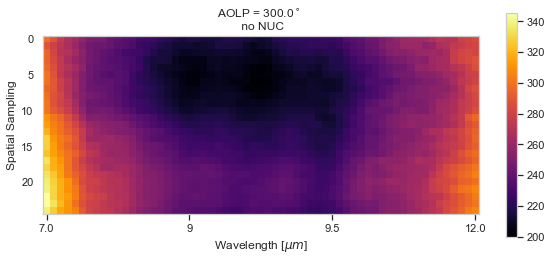

In [98]:
plt.matshow(I1+I2,cmap = 'inferno' )
plt.colorbar()
plt.ylabel('Spatial Sampling')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.title('AOLP = ' + str(lps[j])+ '$^\circ $ \n no NUC')
#plt.clim(cmin,cmax)
plt.show()

In [16]:
# pixel fit 
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x**2 + B

def finv(y,A,B):
    return ((y-B)/A)**0.5


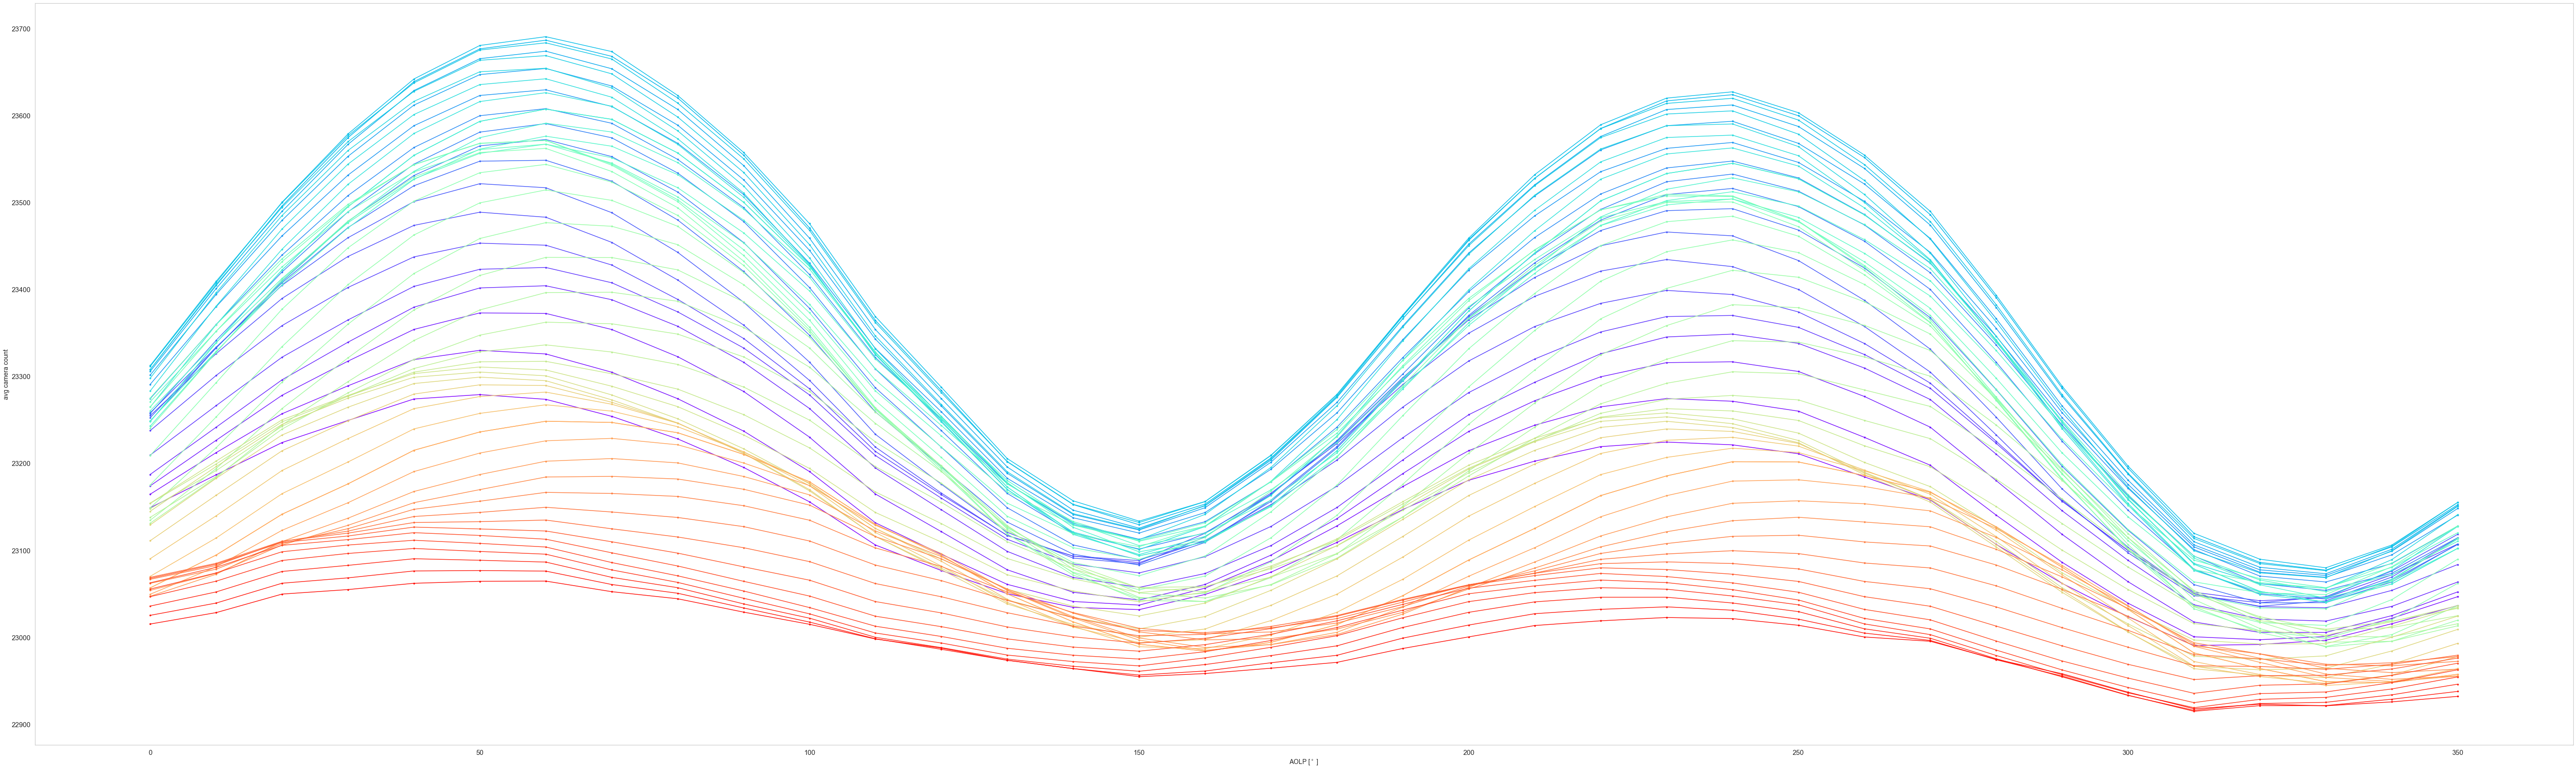

In [199]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(waves)))
w = [0,5,10,15]
for i in range(60):
    plt.plot(df['lps'],get_slice_avg(df['ims2'],i),'.-',c=colors[i],label = str(np.round(waves[i],1)))
    #plt.plot(df['lps'],get_slice_avg(df['ims2'],i),'s',c=colors[i],label = str(np.round(waves[i],1)))
#plt.title('spatially averaged response \n $\lambda = $' + str(round(waves[x],2)) + ' $  \mu m$')
plt.xlabel('AOLP [$^\circ $ ] ')
plt.ylabel('avg camera count')
#plt.legend()
plt.show()


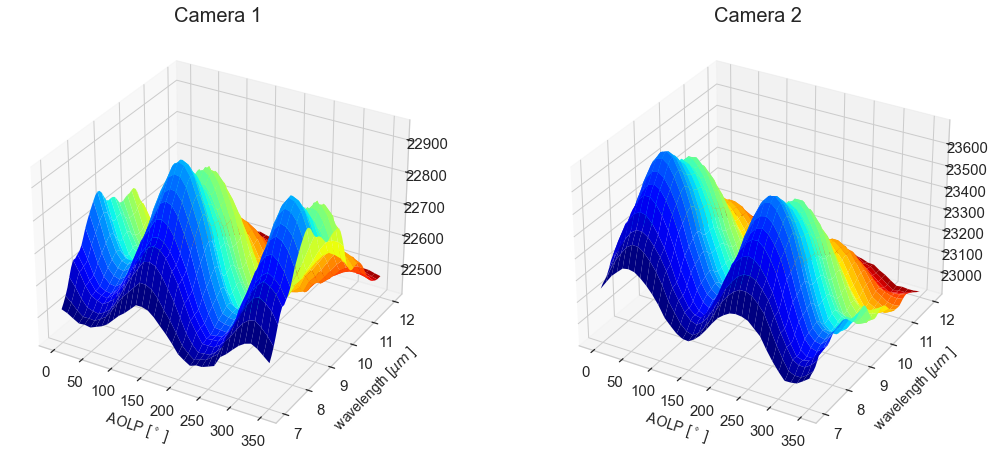

In [231]:
'''first represent raw data'''

from mpl_toolkits.mplot3d import Axes3D


Z1 = np.zeros([len(waves),len(lps)]) 
Z2 = np.zeros([len(waves),len(lps)]) 
for i in range(len(waves)):
    r1=get_slice_avg(df['ims1'],i)
    r2=get_slice_avg(df['ims2'],i)
    Z1[i] =r1
    Z2[i] =r2

X, Y = np.meshgrid(lps,waves)

fig = plt.figure(figsize=(15,6.3))
plt.subplots_adjust(0,0.07,1,1,0,0)

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax = fig.gca(projection='3d')

colors =plt.cm.jet( (Y-Y.min())/float((Y-Y.min()).max()) )

ax1.plot_surface(X,Y,Z1, facecolors=colors, linewidth=0, shade=False )
ax1.set_zlim(np.min(Z1)-2,np.max(Z1)+2)

ax2.plot_surface(X,Y,Z2, facecolors=colors, linewidth=0, shade=False )
ax2.set_zlim(np.min(Z2)-2,np.max(Z2)+2)

ax1.set_title("Camera 1",fontsize = 20)
ax2.set_title("Camera 2",fontsize = 20)

ax1.set_xlabel('\n AOLP [$^\circ $ ] ',fontsize = 14)
ax2.set_xlabel('\n AOLP [$^\circ $ ] ',fontsize = 14)

ax1.set_ylabel('\n wavelength [$\mu m$ ] ',fontsize = 14)
ax2.set_ylabel('\n wavelength [$\mu m $ ] ',fontsize = 14)

plt.show()



In [38]:
def get_slice(df,x,y):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sli.append(s[y,x])
    return(sli)

def get_slice_avg(df,x):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sli.append(np.mean(s[:,x]))
    return(sli)

In [244]:
def get_corrected_avg(df,A, B, t,x):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sc=s - B 
        sli.append(np.mean(sc[:,x])/t)
    return(sli)

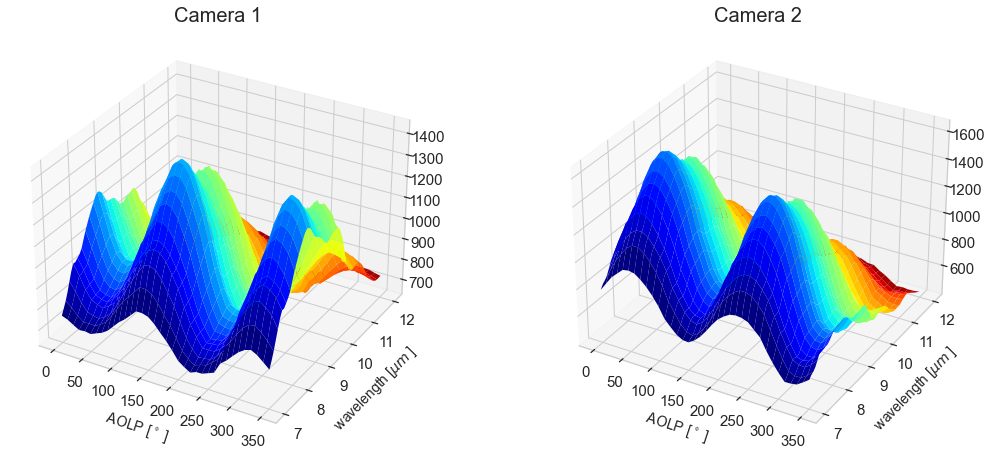

In [245]:

Z1c = np.zeros([len(waves),len(lps)]) 
Z2c = np.zeros([len(waves),len(lps)]) 
for i in range(len(waves)):
    r1=get_corrected_avg(df['ims1'],A1,B1,np.mean(transmission1),i)
    r2=get_corrected_avg(df['ims2'],A2,B2,np.mean(transmission2),i)
    Z1c[i] =r1
    Z2c[i] =r2

X, Y = np.meshgrid(lps,waves)

fig = plt.figure(figsize=(15,6.3))
plt.subplots_adjust(0,0.07,1,1,0,0)

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax = fig.gca(projection='3d')

colors =plt.cm.jet( (Y-Y.min())/float((Y-Y.min()).max()) )

ax1.plot_surface(X,Y,Z1c, facecolors=colors, linewidth=0, shade=False )
ax1.set_zlim(np.min(Z1c)-2,np.max(Z1c)+2)

ax2.plot_surface(X,Y,Z2c, facecolors=colors, linewidth=0, shade=False )
ax2.set_zlim(np.min(Z2c)-2,np.max(Z2c)+2)

ax1.set_title("Camera 1",fontsize = 20)
ax2.set_title("Camera 2",fontsize = 20)

ax1.set_xlabel('\n AOLP [$^\circ $ ] ',fontsize = 14)
ax2.set_xlabel('\n AOLP [$^\circ $ ] ',fontsize = 14)

ax1.set_ylabel('\n wavelength [$\mu m$ ] ',fontsize = 14)
ax2.set_ylabel('\n wavelength [$\mu m $ ] ',fontsize = 14)
plt.show()



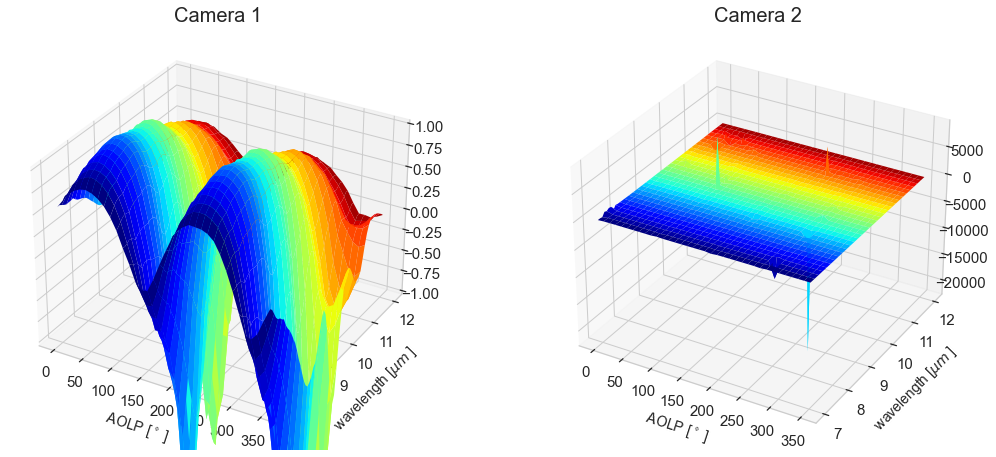

In [246]:
fig = plt.figure(figsize=(15,6.3))
plt.subplots_adjust(0,0.07,1,1,0,0)

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax = fig.gca(projection='3d')

colors =plt.cm.jet( (Y-Y.min())/float((Y-Y.min()).max()) )

ax1.plot_surface(X,Y,((Z1+Z2)/(Z1-Z2)+100)/50, facecolors=colors, linewidth=0, shade=False )
ax1.set_zlim(-1,1)

ax2.plot_surface(X,Y,(Z1c+Z2c)/(Z1c-Z2c), facecolors=colors, linewidth=0, shade=False )


ax1.set_title("Camera 1",fontsize = 20)
ax2.set_title("Camera 2",fontsize = 20)

ax1.set_xlabel('\n AOLP [$^\circ $ ] ',fontsize = 14)
ax2.set_xlabel('\n AOLP [$^\circ $ ] ',fontsize = 14)

ax1.set_ylabel('\n wavelength [$\mu m$ ] ',fontsize = 14)
ax2.set_ylabel('\n wavelength [$\mu m $ ] ',fontsize = 14)
plt.show()



In [266]:
# Plot the test data as a 2D image and the fit as overlaid contours.
k =15
plt.plot(waves,(np.transpose(Z1cn)[k])/np.mean(transmission1))
plt.plot(waves,(np.transpose(Z2cn)[k])/np.mean(transmission2))
#ax.contour(X, Y, fit, colors='w')
plt.show()

NameError: name 'Z1cn' is not defined

In [265]:
np.array(B1)

array([[22059.64507736, 22055.97523705, 22056.74038258, ...,
        22037.16495955, 22035.53093001, 22035.53093001],
       [22051.92560042, 22046.50396657, 22046.52474758, ...,
        22033.06528129, 22025.00996293, 22025.00996293],
       [22048.73429605, 22045.68428962, 22040.84589802, ...,
        22025.01099074, 22036.56546767, 22036.56546767],
       ...,
       [22000.43498921, 21995.86926436, 21991.99703679, ...,
        21971.14993507, 21971.94010891, 21971.94010891],
       [22002.00011439, 21996.74068715, 21983.52997758, ...,
        21979.50874366, 21981.66910485, 21981.66910485],
       [21992.8898788 , 21994.84187624, 21998.38469516, ...,
        21975.16839625, 21971.63699415, 21971.63699415]])